# Exploratory data analysis

##Kallisto
transcripts per million output was obtained from cluster

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
from PIL import Image

In [42]:
c0=sns.color_palette()[0]
c1=sns.color_palette()[1]
c2=sns.color_palette()[2]
c3=sns.color_palette()[3]

In [3]:
from matplotlib.colors import ListedColormap
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

def points_plot(ax, Xtr, Xte, ytr, yte, clf, mesh=True, colorscale=cmap_light, cdiscrete=cmap_bold, alpha=0.1, psize=10, zfunc=False, predicted=False):
    h = .02
    X=np.concatenate((Xtr, Xte))
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))

    #plt.figure(figsize=(10,6))
    if zfunc:
        p0 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 0]
        p1 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
        Z=zfunc(p0, p1)
    else:
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    ZZ = Z.reshape(xx.shape)
    if mesh:
        plt.pcolormesh(xx, yy, ZZ, cmap=cmap_light, alpha=alpha, axes=ax)
    if predicted:
        showtr = clf.predict(Xtr)
        showte = clf.predict(Xte)
    else:
        showtr = ytr
        showte = yte
    ax.scatter(Xtr[:, 0], Xtr[:, 1], c=showtr-1, cmap=cmap_bold, s=psize, alpha=alpha,edgecolor="k")
    # and testing points
    ax.scatter(Xte[:, 0], Xte[:, 1], c=showte-1, cmap=cmap_bold, alpha=alpha, marker="s", s=psize+10)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    return ax,xx,yy

In [4]:
def points_plot_prob(ax, Xtr, Xte, ytr, yte, clf, colorscale=cmap_light, cdiscrete=cmap_bold, ccolor=cm, psize=10, alpha=0.1):
    ax,xx,yy = points_plot(ax, Xtr, Xte, ytr, yte, clf, mesh=False, colorscale=colorscale, cdiscrete=cdiscrete, psize=psize, alpha=alpha, predicted=True) 
    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=ccolor, alpha=.2, axes=ax)
    cs2 = plt.contour(xx, yy, Z, cmap=ccolor, alpha=.6, axes=ax)
    plt.clabel(cs2, fmt = '%2.1f', colors = 'k', fontsize=14, axes=ax)
    return ax 

###Looking at a single file

In [32]:
Fr188_C1=pd.read_csv("/Users/leandraking/Desktop/KallistoFiles/Fr188_C1_TTAGGC/abundance.tsv",sep="\t")


In [33]:
Fr188_C1.head()

,target_id,length,eff_length,est_counts,tpm
0,FBtr0071764,5173,4974,33.8472,0.504464
1,FBtr0100521,4665,4466,179.1580,2.973920
2,FBtr0071763,4847,4648,142.0220,2.265180
3,FBtr0342981,3897,3698,36.9729,0.741191
4,FBtr0083388,3935,3736,103.4280,2.052320


Checking that tpm sum up to 1000000

In [34]:
sum(Fr188_C1.tpm) , len(Fr188_C1)

(999999.92981562519, 30446)

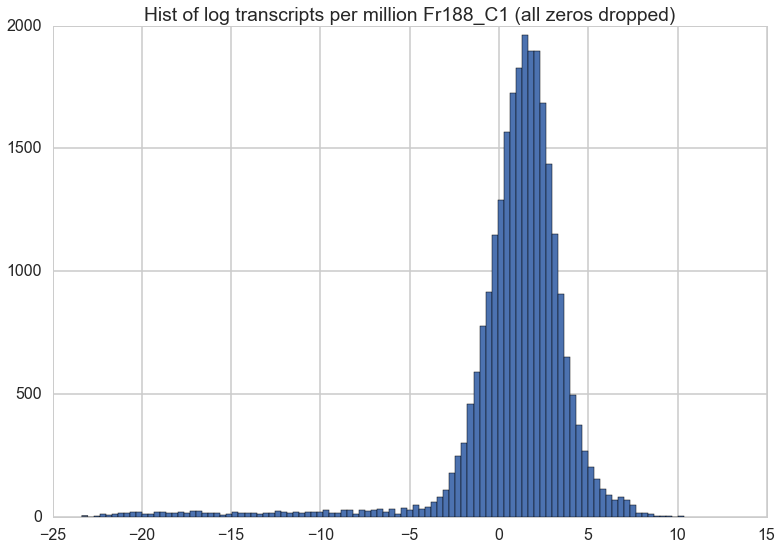

In [35]:
plt.hist(np.log(Fr188_C1[Fr188_C1.tpm>0].tpm), bins=100)
plt.title("Hist of log transcripts per million Fr188_C1 (all zeros dropped)")
plt.show()

###Looking at the output of all Fr files

In [36]:
#Create a dataframe with tpm data from all files
import glob
import string
files_dict={}
for fl in glob.glob("../KallistoFiles/*"):
    a= string.join(fl.split('/')[2].split('_')[:2], sep="_")
    if a:
        files_dict[a]=pd.read_csv(fl+"/abundance.tsv", sep="\t").tpm

LoadedData=pd.DataFrame(files_dict)

In [37]:
LoadedData.head()

,Fr188_C1,Fr188_C2,Fr188_C3,Fr188_T3,Fr188_T5,Fr188_T6,Fr89_C1,Fr89_C2,Fr89_C4,Fr89_T3,Fr89_T4,Fr89_T5,Zi238_C1,Zi238_C2,Zi238_C3,Zi238_C4,Zi238_T2,Zi238_T3,Zi238_T4,Zi257_C1,Zi257_C2,Zi257_C3,Zi257_T1,Zi257_T2,Zi257_T3,Zi257_T4
0,0.504464,1.284890,0.614044,0.00000,0.000000,0.000000,0.440369,0.691164,0.262204,0.000000,0.147861,0.00000,0.440267,0.652083,0.894199,0,1.548400e-01,0.000000,0.133242,0.00000,0.57178,0.37936,0.000000,0.105309,0.00000,0.00000
1,2.973920,4.151500,5.322480,3.70415,5.352650,3.635080,10.496100,8.771190,1.165150,4.027210,3.819260,5.20589,4.586930,5.192110,1.115020,0,4.127860e+00,3.603360,4.166850,5.08526,8.40361,6.08674,5.779740,4.997630,3.46231,5.69248
2,2.265180,1.434560,0.000000,0.00000,0.000000,0.461069,1.724620,0.563522,5.122970,0.000000,0.000000,0.00000,2.278640,1.485840,5.823160,0,0.000000e+00,0.000000,0.351757,5.27287,0.00000,4.23550,0.413694,0.000000,0.32999,0.00000
3,0.741191,0.350953,0.000484,0.00000,0.445147,0.000000,0.923483,0.000000,1.166280,0.158618,0.428323,0.00000,0.429408,0.000000,0.000000,0,1.491710e-07,0.411839,0.000000,0.00000,0.00000,0.00000,0.000000,0.000000,0.00000,0.00000
4,2.052320,0.690347,1.806490,3.43484,4.507330,4.265000,2.172480,0.869259,1.108070,3.678080,3.580640,3.87075,2.379780,2.346690,3.902570,0,4.123990e+00,5.012800,4.700970,1.88296,2.12189,2.37721,4.582620,3.783650,4.41964,2.67030


###Do a PCA

In [38]:
from sklearn.decomposition import PCA
pca = PCA(n_components=50)
X = pca.fit_transform(LoadedData.transpose())

In [39]:
print pca.explained_variance_ratio_.sum()

1.0


In [40]:
pca.explained_variance_ratio_*100

array([  7.52801689e+01,   1.72597998e+01,   4.90974923e+00,
         9.45304187e-01,   5.52002110e-01,   3.54150269e-01,
         2.72988302e-01,   9.53703335e-02,   8.94500230e-02,
         6.78247285e-02,   3.69397135e-02,   2.37528529e-02,
         2.27045440e-02,   1.64706681e-02,   1.36633287e-02,
         1.27654231e-02,   1.17467993e-02,   7.89890982e-03,
         6.32380373e-03,   5.42984463e-03,   4.41862789e-03,
         3.87113957e-03,   3.32985515e-03,   2.57134247e-03,
         1.30524287e-03,   1.03545849e-28])

The variance is really explained here by the first two components

In [41]:
#Labeling with either a C or T
TorClabels=[a.split('_')[1][0] for a in LoadedData.columns]
lineLabels=[filter(str.isdigit,a.split('_')[0]) for a in LoadedData.columns]
countryLabels=[a[:2] for a in LoadedData.columns]
dfPCA = pd.DataFrame({"TorC":TorClabels, "lines":lineLabels, "country":countryLabels})
for i in range(pca.explained_variance_ratio_.shape[0]):
    dfPCA["pc%i" % (i+1)] = X[:,i]
dfPCA


,TorC,country,lines,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,pc11,pc12,pc13,pc14,pc15,pc16,pc17,pc18,pc19,pc20,pc21,pc22,pc23,pc24,pc25,pc26
0,C,Fr,188,-77861.212494,-20579.532686,189.496710,-20533.003250,167.058036,-1471.608864,5322.687246,-784.681769,2085.963593,-3789.205860,2922.461683,-499.323103,-1796.480254,1020.716837,1630.082631,2405.584889,1340.180561,-329.985166,-373.460795,-335.212381,-157.912675,-12.357166,-64.871539,-51.442106,-41.954812,-9.635260e-11
1,C,Fr,188,-79481.413308,-19918.021405,2440.643167,-6389.973790,1330.481159,574.600991,-3268.615543,89.951099,-2724.114930,1484.747413,-2518.907157,-81.511894,1407.733065,1660.070632,-690.114787,-865.539749,1944.767066,-565.993597,-1443.132395,734.682713,-287.727586,315.623118,-1224.162393,-567.792649,-2.082639,-9.635260e-11
2,C,Fr,188,-77842.080732,-15803.318013,-1966.579994,16735.661162,-2738.120782,-1175.183780,-3210.845955,242.083614,-1916.295274,-4847.769238,-1478.543633,743.738225,1131.632639,2829.512050,295.057571,513.756239,745.900457,21.548802,1100.687861,815.907370,478.223358,-431.472921,647.329424,629.091470,129.376831,-9.635260e-11
3,T,Fr,188,58623.691167,1323.325916,-95951.630416,1825.564434,6253.525368,3712.598062,2516.612804,1286.962613,-965.881743,111.698729,368.954757,755.340925,-451.598481,68.494108,542.504185,-398.777641,-52.131248,123.001964,-42.662084,33.658323,213.808730,379.013543,-90.882021,-54.618358,202.298238,-9.635260e-11
4,T,Fr,188,78462.061972,1756.560923,8353.103837,1913.075529,4074.178346,3287.373496,1000.186467,-1876.912076,1981.438476,-455.455201,-1223.743537,-1303.198620,1877.768617,-1296.193727,-1091.550489,2108.431432,497.586018,484.493742,335.146357,170.181669,893.477856,1638.028593,-420.379213,622.492252,-219.950251,-9.635260e-11
5,T,Fr,188,95112.715682,3632.929481,-2121.465440,-4571.491014,-11027.603812,-2904.803051,-3979.437264,-9087.474587,1818.110652,309.764479,-1495.565242,3684.575386,-955.415513,-387.426786,70.513698,-264.721055,130.075871,-1158.812477,7.174275,-280.583199,151.435437,73.645961,66.121928,73.224859,101.421597,-9.635260e-11
6,C,Fr,89,-72345.467140,-16925.120707,3217.270937,9490.509301,1646.655305,1250.269822,-5518.279509,297.982348,2567.242834,218.081256,1414.728710,395.049781,118.270486,-573.773250,447.105118,173.042277,-1071.307518,-262.608885,-1868.791253,989.600574,-842.900189,938.460884,1324.974939,-65.214445,-97.110113,-9.635260e-11
7,C,Fr,89,-86973.347389,-21397.427009,-484.812748,-11128.064743,1002.648957,310.605147,-1865.644535,743.894318,-1775.586352,5101.087377,-1159.844221,-420.165716,-1147.854172,245.013433,219.027247,1468.665715,-2615.669605,-995.588954,1204.134363,1226.631444,55.203821,-169.638770,-335.552523,143.145814,46.536877,-9.635260e-11
8,C,Fr,89,-83529.546423,-16705.344734,-1588.784673,10241.953603,-7480.291301,-3503.980229,16873.176589,-762.925741,5960.603264,3206.728239,19.232196,295.801061,1092.179940,821.371100,-721.792412,-563.010415,-254.363462,225.107408,39.442693,156.019117,303.752169,-219.778943,35.961859,-383.462027,-159.723444,-9.635260e-11
9,T,Fr,89,85310.553746,3043.187831,7733.378549,-2969.006163,-8318.719777,-1998.819669,1530.736022,6856.432170,-3756.086346,206.625405,2559.642009,2813.041550,-1250.469310,402.667466,-2287.597243,88.352929,194.199823,-185.517505,-96.921507,7.588956,5.164091,249.612211,9.982929,353.484652,-604.129539,-9.635260e-11


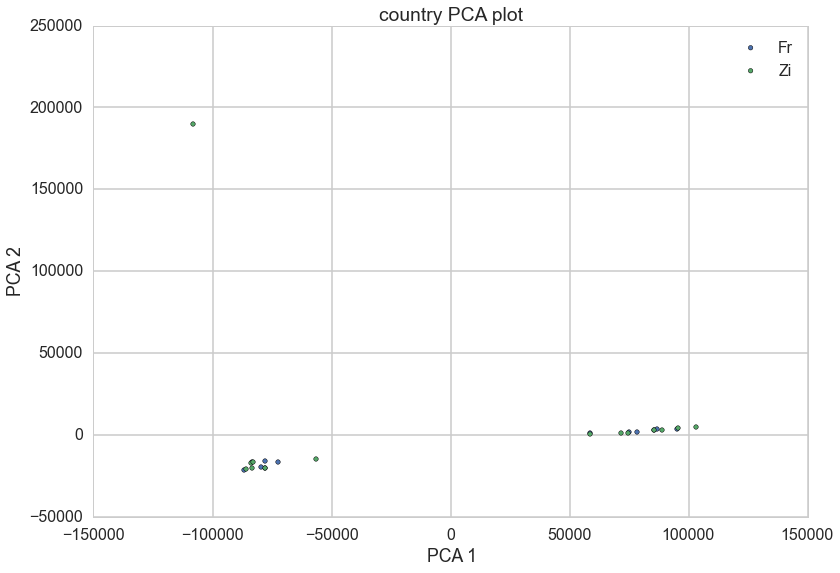

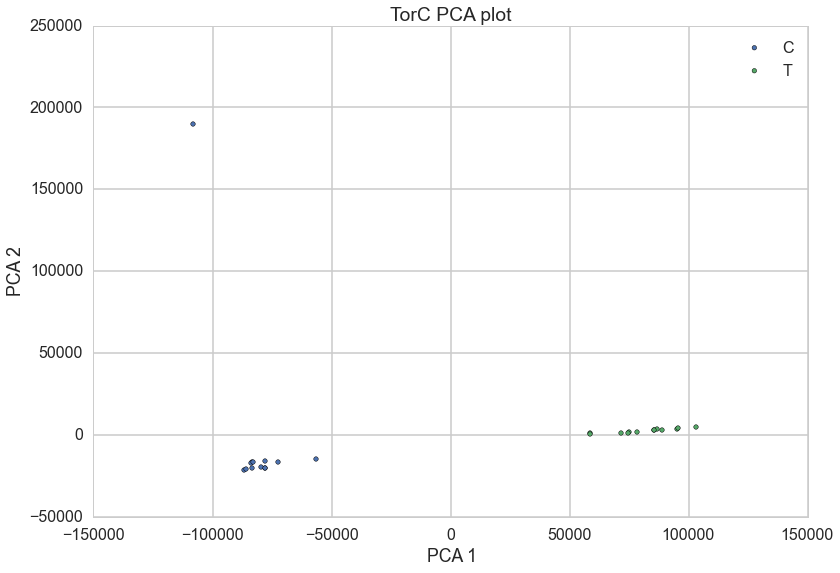

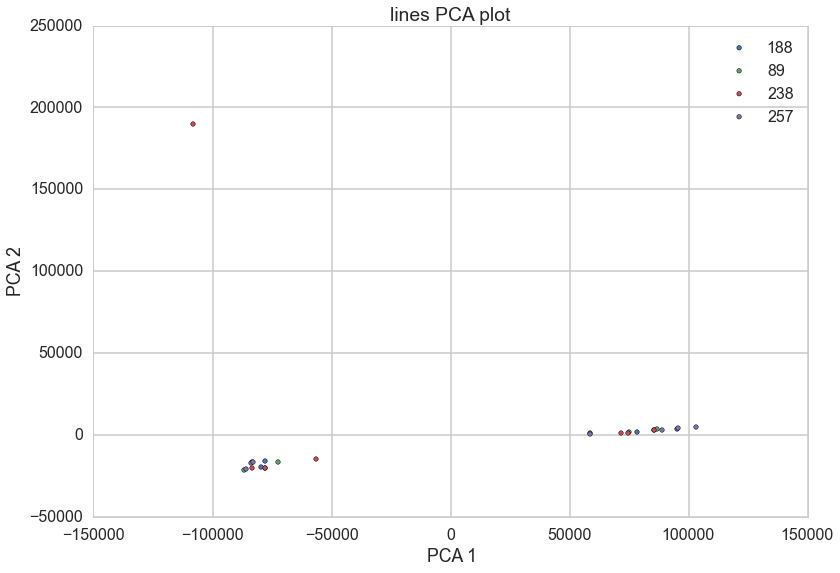

In [44]:
def plot_PCA(labelName, df):
    plt.figure()
    colors = [c0, c1, c2, c3]
    for label, color in zip(df[labelName].unique(), colors):
        mask = df[labelName]==label
        plt.scatter(df[mask]['pc1'], df[mask]['pc2'], c=color, label=label)
    plt.legend()
    plt.title(labelName +" PCA plot")
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    plt.show()

plot_PCA("country",dfPCA)
plot_PCA("TorC", dfPCA)
plot_PCA("lines",dfPCA)

Carcass points cluster together.  Lines do not cluster together.  Zimbabwe carcass 238 sticks out.

##Let's now consider carcass only carcass data

In [46]:
TorClabels=[a.split('_')[1][0] for a in LoadedData.columns]
dfCarcass=LoadedData[[col for lab,col in zip(TorClabels,LoadedData.columns) if lab=="C"]]
pca = PCA(n_components=10)
X = pca.fit_transform(dfCarcass.transpose())
pca.explained_variance_ratio_*100

array([  9.10958471e+01,   4.80569098e+00,   2.43018572e+00,
         8.50772957e-01,   3.54542235e-01,   1.59593350e-01,
         1.07489149e-01,   7.13043025e-02,   3.90139079e-02,
         3.33718468e-02])

In [51]:
lineLabels=[filter(str.isdigit,a.split('_')[0]) for a in dfCarcass.columns]
countryLabels=[a[:2] for a in dfCarcass.columns]
dfCarcassPCA = pd.DataFrame({"lines":lineLabels, "country":countryLabels})
for i in range(pca.explained_variance_ratio_.shape[0]):
    dfCarcassPCA["pc%i" % (i+1)] = X[:,i]
dfCarcassPCA

,country,lines,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10
0,Fr,188,-18380.593320,-19738.170553,846.630880,7951.055475,3374.199978,5233.936568,798.436897,536.068240,706.339084,-800.148744
1,Fr,188,-17505.450358,-6409.065617,2240.088384,-3900.891113,-1080.333820,-880.906365,2912.215671,-2732.142779,2098.731239,577.492617
2,Fr,188,-13657.100324,17213.169682,-1089.067777,-3111.485412,5286.767074,88.748625,3716.998743,452.724265,-1552.639427,-934.981107
3,Fr,89,-15530.766120,10517.257816,8006.483538,-512.609523,-757.319078,-1889.019206,-2013.471635,1559.558688,1213.205544,-2455.884423
4,Fr,89,-17935.176914,-12365.255944,-4315.368743,-5794.967454,-4676.635178,1413.849259,-22.295240,3166.561230,-777.552436,919.037679
5,Fr,89,-13750.828921,9454.714236,-15914.826100,13217.152247,-3751.506686,-2340.453773,757.088586,84.632108,-5.258376,254.818581
6,Zi,238,-15868.055401,11550.688112,24032.432030,5738.694433,-1147.921798,783.989844,-930.282268,-451.164337,-767.947578,1485.632979
7,Zi,238,-17994.227794,-13142.815514,6504.758045,-3033.335364,-4490.188676,-2338.785400,1972.259819,176.802974,-512.749462,-536.931282
8,Zi,238,-17119.783480,-14460.626204,-1494.976399,-3.639288,7470.092908,-4245.824454,-1849.659289,911.976217,427.607903,1150.354999
9,Zi,238,194012.564686,-1261.093345,263.741760,-69.427667,-45.093265,18.762765,-10.856414,-11.664385,1.217462,-4.495477


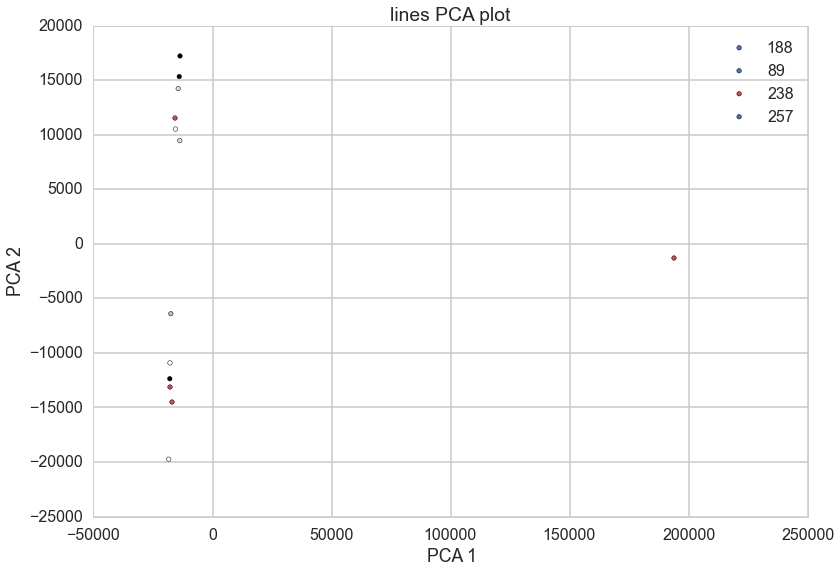

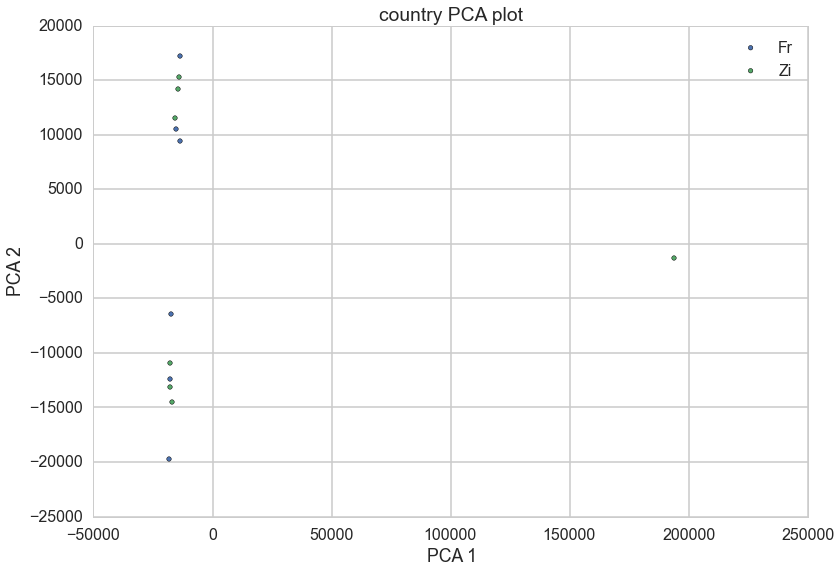

In [49]:
plot_PCA("lines",dfCarcassPCA)
plot_PCA("country", dfCarcassPCA)